In [2]:
import pandas as pd

# Path to the CSV file (adjust the path if necessary)
file_path = 'roaster_data.csv'

# Load the CSV file into a DataFrame
roaster_data = pd.read_csv(file_path, header=None)  # Use header=None if the file has no headers

# Optionally, you can assign column names for clarity
roaster_data.columns = ['Timestamp', 'Heater value', 'Fan Value', 'BeanTemp', 'EnvTemp']

# Display the first few rows of the data
roaster_data.head()


,Timestamp,Heater value,Fan Value,BeanTemp,EnvTemp
0,1.725700e+09,10,50,136.19,180.08
1,1.725700e+09,10,50,135.84,179.55
2,1.725700e+09,10,50,135.67,179.47
3,1.725700e+09,10,50,135.04,178.38
4,1.725700e+09,10,50,134.30,177.24


In [6]:
import os
import pandas as pd

# Path to the original CSV file
file_path = 'roaster_data.csv'

# Create the 'data' folder if it doesn't exist
output_folder = 'data'
os.makedirs(output_folder, exist_ok=True)

# Load the CSV file into a DataFrame
roaster_data = pd.read_csv(file_path, header=None)
roaster_data.columns = ['Timestamp', 'Heater Value', 'Fan Value', 'BeanTemp', 'EnvTemp']

# Initialize variables for splitting
file_index = 1
previous_timestamp = None
split_data = []

# Loop through the data to split based on timestamp gap
for i, row in roaster_data.iterrows():
    current_timestamp = row['Timestamp']
    
    # If there's a previous timestamp, check the gap
    if previous_timestamp is not None:
        if current_timestamp - previous_timestamp > 10:
            # Save the current split_data to a new file in the 'data' folder
            split_df = pd.DataFrame(split_data, columns=roaster_data.columns)
            split_df.to_csv(f'{output_folder}/roaster_data_{file_index}.csv', index=False)
            file_index += 1
            # Reset split_data for the next file
            split_data = []
    
    # Append the current row to the split data
    split_data.append(row)
    # Update the previous timestamp
    previous_timestamp = current_timestamp

# Save the last split data if there's any remaining
if split_data:
    split_df = pd.DataFrame(split_data, columns=roaster_data.columns)
    split_df.to_csv(f'{output_folder}/roaster_data_{file_index}.csv', index=False)


In [16]:
import pandas as pd

# Path to the CSV file (adjust the path if necessary)
file_path = 'data/roaster_data_1.csv'

# Load the CSV file into a DataFrame
roaster_data = pd.read_csv(file_path, header=None)  # Use header=None if the file has no headers

# Optionally, you can assign column names for clarity
roaster_data.columns = ['Timestamp', 'Heater value', 'Fan Value', 'BeanTemp', 'EnvTemp']

# Display the first few rows of the data
roaster_data.head()


,Timestamp,Heater value,Fan Value,BeanTemp,EnvTemp
0,Timestamp,Heater Value,Fan Value,BeanTemp,EnvTemp
1,1725699696.0838542,10.0,50.0,136.19,180.08
2,1725699697.75904,10.0,50.0,135.84,179.55
3,1725699699.273598,10.0,50.0,135.67,179.47
4,1725699701.032834,10.0,50.0,135.04,178.38


In [18]:
import tensorflow as tf
import pandas as pd

# Load the dataset
file_path = 'data/roaster_data_1.csv'  # Adjust the file path as necessary
roaster_data = pd.read_csv(file_path)

# Create the 'Set Temp' column: use the 'BeanTemp' of the next record as the target temperature
roaster_data['Set Temp'] = roaster_data['BeanTemp'].shift(-1)

# Remove rows with NaN values resulting from the shift
roaster_data.dropna(inplace=True)

# Prepare input features: Previous Heater Value, Fan Value, BeanTemp, EnvTemp, and Set Temp
input_features = roaster_data[['Heater Value', 'Fan Value', 'BeanTemp', 'EnvTemp', 'Set Temp']].values
output_labels = roaster_data['Heater Value'].shift(-1).dropna().values  # The next Heater Value as the target

# Ensure the input features and output labels have the same length
input_features = input_features[:-1]  # Remove the last row to match the length of output_labels

# Convert to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((input_features, output_labels))

# Set window size and shift
window_size = 5
shift = 1

# Function to create windows
def create_windows(features, labels):
    feature_windows = tf.data.Dataset.from_tensor_slices(features).window(window_size, shift=shift, drop_remainder=True)
    label_windows = tf.data.Dataset.from_tensor_slices(labels).window(window_size, shift=shift, drop_remainder=True)

    # Flatten the windows into batches and combine them
    feature_windows = feature_windows.flat_map(lambda window: window.batch(window_size))
    label_windows = label_windows.flat_map(lambda window: window.batch(window_size))

    return tf.data.Dataset.zip((feature_windows, label_windows))

# Create windowed dataset
windowed_dataset = create_windows(input_features, output_labels)

# Map features and labels: use all but the last element in each window as input, and the next heater value as output
windowed_dataset = windowed_dataset.map(lambda x, y: (x[:-1], y[-1]))

# Print the first 10 windows to verify
count = 0
for x, y in windowed_dataset:
    print("x =", x.numpy())  # Includes the 'Heater Value', 'Fan Value', 'BeanTemp', 'EnvTemp', and 'Set Temp'
    print("y =", y.numpy())  # Predicts the next 'Heater Value'
    print()
    count += 1
    if count == 10:
        break


x = [[ 10.    50.   136.19 180.08 135.84]
 [ 10.    50.   135.84 179.55 135.67]
 [ 10.    50.   135.67 179.47 135.04]
 [ 10.    50.   135.04 178.38 134.3 ]]
y = 10.0

x = [[ 10.    50.   135.84 179.55 135.67]
 [ 10.    50.   135.67 179.47 135.04]
 [ 10.    50.   135.04 178.38 134.3 ]
 [ 10.    50.   134.3  177.24 131.4 ]]
y = 10.0

x = [[ 10.    50.   135.67 179.47 135.04]
 [ 10.    50.   135.04 178.38 134.3 ]
 [ 10.    50.   134.3  177.24 131.4 ]
 [ 10.    50.   131.4  173.98 128.92]]
y = 10.0

x = [[ 10.    50.   135.04 178.38 134.3 ]
 [ 10.    50.   134.3  177.24 131.4 ]
 [ 10.    50.   131.4  173.98 128.92]
 [ 10.    50.   128.92 171.75 123.62]]
y = 10.0

x = [[ 10.    50.   134.3  177.24 131.4 ]
 [ 10.    50.   131.4  173.98 128.92]
 [ 10.    50.   128.92 171.75 123.62]
 [ 10.    50.   123.62 166.49 120.73]]
y = 10.0

x = [[ 10.    50.   131.4  173.98 128.92]
 [ 10.    50.   128.92 171.75 123.62]
 [ 10.    50.   123.62 166.49 120.73]
 [ 10.    50.   120.73 163.56 115.51]]
y = 10.0

In [83]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
window_size = 120  # Use a window of 30 timesteps

# Load the dataset
file_path = 'data/roaster_data_12.csv'  # Adjust the file path as necessary
roaster_data = pd.read_csv(file_path)

# Create the 'Set Temp' column: use the 'BeanTemp' of the next record as the target temperature
roaster_data['Set Temp'] = roaster_data['BeanTemp'].shift(-1)

# Remove rows with NaN values resulting from the shift
roaster_data.dropna(inplace=True)

# Prepare input features
input_features = roaster_data[['Heater Value', 'Fan Value', 'BeanTemp', 'EnvTemp', 'Set Temp']].values
output_labels = roaster_data['Heater Value'].shift(-1).dropna().values

# Create sliding windows
X = []
y = []

for i in range(len(input_features) - window_size):
    X.append(input_features[i:i + window_size])
    y.append(output_labels[i + window_size - 1])  # Predict the next heater value

X = np.array(X)
y = np.array(y)

# Split the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the training and validation data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(1)

# Build an LSTM model for sequence learning
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, 5)),
#     tf.keras.layers.LSTM(32),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(1)  # Output: Heater Value
# ])
# Build a more complex LSTM model for sequence learning
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(window_size, 5)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Output: Heater Value
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(train_dataset, epochs=60, validation_data=val_dataset, callbacks=[early_stopping])
# ,verbose=0)

# Print the training and validation loss
print(f"Training Loss: {history.history['loss'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


Epoch 1/60


/home/cristianku/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1128.4714 - mae: 27.0025 - val_loss: 1190.7845 - val_mae: 27.6307
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 995.8708 - mae: 25.4253 - val_loss: 1018.7834 - val_mae: 25.4039
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 806.2316 - mae: 22.7026 - val_loss: 796.0363 - val_mae: 22.3800
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 627.3986 - mae: 20.1787 - val_loss: 593.5864 - val_mae: 19.9968
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 470.7564 - mae: 17.7015 - val_loss: 479.6057 - val_mae: 18.9128
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 399.1286 - mae: 17.0998 - val_loss: 459.0833 - val_mae: 18.8746
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 404.1708 - mae: 17.1801 - val_loss: 458.9689 - val_mae: 18.8711
Epoch 8/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 402.6234 - mae: 17.1884 - val_loss: 436.8412 - val_mae: 18.2042
Epoch 9/60
23/23 ━━━━━━━

In [84]:
import numpy as np
import pandas as pd

# Load the dataset and print the first 5 rows
file_path_2 = 'data/roaster_data_12.csv'  # Adjust the file path as necessary
roaster_data_2 = pd.read_csv(file_path_2)

# Display the first 30 rows
print("First 30 rows of the dataset:")
print(roaster_data_2.head(31))

# Create the 'Set Temp' column: use the 'BeanTemp' of the next record as the target temperature
roaster_data_2['Set Temp'] = roaster_data_2['BeanTemp'].shift(-1)

# Remove rows with NaN values resulting from the shift
roaster_data_2.dropna(inplace=True)

# Prepare input features
input_features_2 = roaster_data_2[['Heater Value', 'Fan Value', 'BeanTemp', 'EnvTemp', 'Set Temp']].values

# Initialize the input window of size 30 (use the first 30 rows for the prediction window)
window_size = 120
prediction_window = input_features_2[:window_size]

# Reshape the input to match the LSTM model's expected shape (1, 30, 5)
prediction_window = np.expand_dims(prediction_window, axis=0)

# Perform the prediction
predicted_value = model.predict(prediction_window)[0][0]

# Print the prediction result
print(f"Predicted Heater Value based on the first 30 rows: {predicted_value}")


First 30 rows of the dataset:
       Timestamp  Heater Value  Fan Value  BeanTemp  EnvTemp
0   1.725703e+09          40.0       40.0    157.18   164.16
1   1.725703e+09          40.0       40.0    157.46   164.30
2   1.725703e+09          40.0       40.0    157.46   164.33
3   1.725703e+09          40.0       40.0    157.53   164.37
4   1.725703e+09          40.0       40.0    157.57   164.48
5   1.725703e+09          40.0       40.0    157.46   164.58
6   1.725703e+09          40.0       40.0    157.53   164.69
7   1.725703e+09          40.0       40.0    157.57   164.79
8   1.725703e+09          40.0       40.0    157.64   164.83
9   1.725703e+09          40.0       40.0    157.67   164.97
10  1.725703e+09          40.0       40.0    157.67   165.04
11  1.725703e+09          40.0       40.0    157.81   165.25
12  1.725703e+09          40.0       40.0    157.88   165.29
13  1.725703e+09          40.0       40.0    157.99   165.36
14  1.725703e+09          40.0       40.0    158.06   1

In [56]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming model, window_size, and early_stopping have already been defined

# Define the ReduceLROnPlateau callback (since it's missing in the current code)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# Load the second dataset
file_path_2 = 'data/roaster_data_12.csv'  # Adjust the file path to your second dataset
roaster_data_2 = pd.read_csv(file_path_2)

# Create the 'Set Temp' column: use the 'BeanTemp' of the next record as the target temperature
roaster_data_2['Set Temp'] = roaster_data_2['BeanTemp'].shift(-1)

# Remove rows with NaN values resulting from the shift
roaster_data_2.dropna(inplace=True)

# Prepare input features and labels for sliding windows
input_features_2 = roaster_data_2[['Heater Value', 'Fan Value', 'BeanTemp', 'EnvTemp', 'Set Temp']].values
output_labels_2 = roaster_data_2['Heater Value'].shift(-1).dropna().values

# Create sliding windows
X_2 = []
y_2 = []

for i in range(len(input_features_2) - window_size):
    X_2.append(input_features_2[i:i + window_size])
    y_2.append(output_labels_2[i + window_size - 1])  # Predict the next heater value

X_2 = np.array(X_2)
y_2 = np.array(y_2)

# Convert the new data into a TensorFlow dataset
train_dataset_2 = tf.data.Dataset.from_tensor_slices((X_2, y_2)).batch(32).shuffle(1000).prefetch(1)

# Continue training the existing model with the new data
history_2 = model.fit(train_dataset_2, epochs=100, callbacks=[early_stopping, reduce_lr])

# Print the final training loss on the new data
print(f"Training Loss on second file: {history_2.history['loss'][-1]}")


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 83.6518 - mae: 7.0441 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.0521 - mae: 6.3767 - learning_rate: 0.0010
Epoch 3/100
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.1303 - mae: 6.4947

/home/cristianku/.local/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.4252 - mae: 6.2226 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.7219 - mae: 5.9657 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.8923 - mae: 3.5504 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7434 - mae: 3.5728 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.2674 - mae: 3.4954 - learning_rate: 0.0010
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.6427 - mae: 2.6572 - learning_rate: 0.0010
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.0545 - mae: 3.8551 - learning_rate: 0.0010
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.3364 - mae: 2.4520 - learning_rate: 0.0010
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.2196 - mae: 2.7513 - learning_rate: 0.0010
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.50

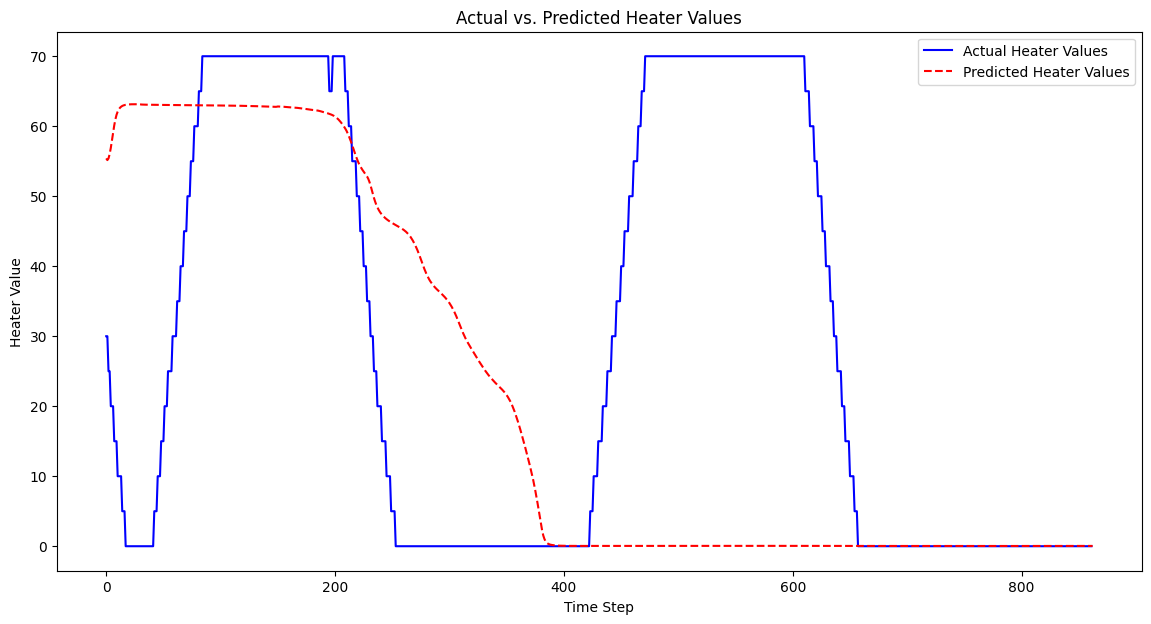

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path_2 = 'data/roaster_data_18.csv'  # Adjust the file path as necessary
roaster_data_2 = pd.read_csv(file_path_2)

# Display the first 30 rows
# print("First 30 rows of the dataset:")
# print(roaster_data_2.head(30))

# Create the 'Set Temp' column: use the 'BeanTemp' of the next record as the target temperature
roaster_data_2['Set Temp'] = roaster_data_2['BeanTemp'].shift(-1)

# Remove rows with NaN values resulting from the shift
roaster_data_2.dropna(inplace=True)

# Prepare input features
input_features_2 = roaster_data_2[['Heater Value', 'Fan Value', 'BeanTemp', 'EnvTemp', 'Set Temp']].values

# Get the actual heater values to compare later
actual_heater_values = roaster_data_2['Heater Value'].shift(-1).dropna().values

# Initialize variables for the sliding window predictions
window_size = 120  # Update window size to 30 points
predicted_heater_values = []

# Initialize the first window
current_window = input_features_2[:window_size].tolist()  # Use the first 30 rows to start

# Perform predictions using a sliding window approach
num_predictions = len(input_features_2) - window_size  # Number of predictions to make
for i in range(num_predictions):
    # Prepare the current window for prediction (reshape to (1, 30, 5))
    window_array = np.expand_dims(np.array(current_window), axis=0)
    
    # Make the prediction
    predicted_value = model.predict(window_array,verbose=0)[0][0]
    predicted_heater_values.append(predicted_value)
    
    # Slide the window forward
    if i + window_size < len(input_features_2):
        next_input_row = input_features_2[i + window_size].copy()
        next_input_row[0] = predicted_value  # Replace 'Heater Value' with the predicted value
        current_window.append(next_input_row)  # Add the new row to the window
        current_window.pop(0)  # Remove the oldest row to maintain window size

# Align the predicted values with the actual values for plotting
actual_heater_values = actual_heater_values[window_size:]

# Plot the actual vs. predicted heater values
plt.figure(figsize=(14, 7))
plt.plot(range(len(actual_heater_values)), actual_heater_values, label='Actual Heater Values', color='blue')
plt.plot(range(len(predicted_heater_values)), predicted_heater_values, label='Predicted Heater Values', color='red', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heater Value')
plt.title('Actual vs. Predicted Heater Values')
plt.legend()
plt.show()
